In [98]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import pad_sequences,to_categorical
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\itzbi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [69]:
train_data = pd.read_parquet('train.parquet')
val_data = pd.read_parquet('val.parquet')
test_data = pd.read_parquet('test.parquet')
train_data.head()

text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

In [71]:
print("Train Data shape: ",train_data.shape) #Printing the shape train data
print("Test Data shape: ",test_data.shape) #Printing the shape test data
print("Validation Data shape: ",val_data.shape) #Printing the shape validation data

Train Data shape:  (16000, 2)
Test Data shape:  (2000, 2)
Validation Data shape:  (2000, 2)


In [72]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [73]:
all_text = ' '.join(pd.concat([train_df['text'], val_df['text'], test_df['text']], axis=0))

In [74]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

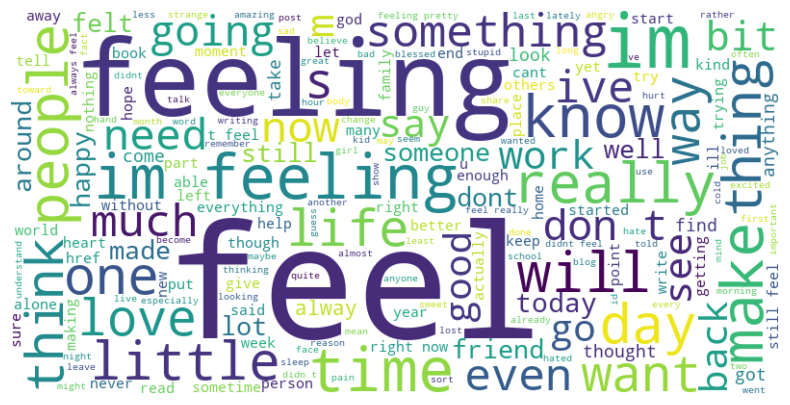

In [75]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [76]:
train_data['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='text'>

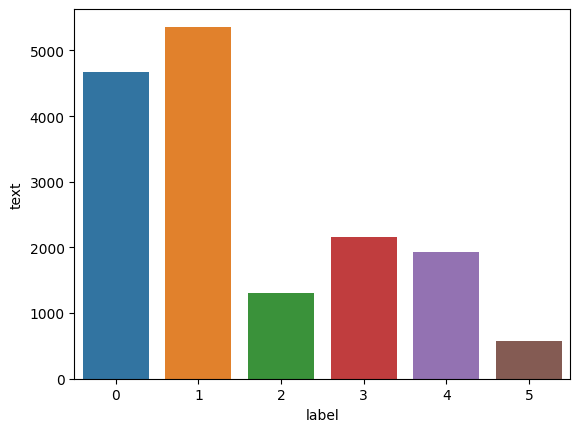

In [85]:
sns.barplot(train_data.groupby('label').count().reset_index(), x='label', y='text')

In [90]:
print("The Null value rows present in the trianing dataset is : ",train_data.isna().sum())    # Printing the null value present in the training dataset
print("The Duplicate rows present in the training dataset is : ",train_data.duplicated().sum())   # Printing the duplicated value present in the training dataset

The Null value rows present in the trianing dataset is :  text     0
label    0
dtype: int64
The Duplicate rows present in the training dataset is :  1


In [91]:
train_data.drop_duplicates(keep = 'first',inplace=True) # Dropping the duplicated values and keeping the first value in the dataset

In [92]:
print("Now the Duplicate rows present in the training dataset is : ",train_data.duplicated().sum()) # After Dropping now the duplicated values are zero
print("Now the shape of the training dataset is ",train_data.shape) # After dropping the duplicates the rows of the training data reduce

Now the Duplicate rows present in the training dataset is :  0
Now the shape of the training dataset is  (15999, 2)


In [99]:
## Perfoming the text preprocessing

nltk.download('stopwords')  # Downloading all the stopwords from the nltk library
pattern = re.compile('<.*?>')  # Pattern for removing the HTML tags
punctuation = string.punctuation   # Extracting all punctuation from the string library
ps = PorterStemmer()  # Creating a PorterStemmer object for the stemming purpose
tokenizer = Tokenizer() # Creating a Tokenizer object for representing the text into numeric form

def text_preprocess(text):

  text = re.sub(pattern,'',text)  # Removing the HTML tags using re library

  text = text.lower()  # Lower case all the character present in the text

  text = text.translate(str.maketrans('','',punctuation))   # Removing all the punctuation from the text

  text = text.split()    # word tokenize the text

  text = [ps.stem(word) for word in text if word not in stopwords.words('english')]  # Removing the stopwords from the text and stem each word

  return ' '.join(text)  # Join each word for the formation of clear text in string form

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itzbi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
processed_train_data = [text_preprocess(words) for words in train_data['text']]   # Applying the text pre-processing fuction to the text column of train dataset
processed_val_data = [text_preprocess(words) for words in val_data['text']]  # Applying the text pre-processing fuction to the text column of validation dataset
processed_test_data = [text_preprocess(words) for words in test_data['text']]   # Applying the text pre-processing fuction to the text column of test dataset

In [102]:
# Putting all the processed text of train data into a whole text. Then fit this whole text into the tokenizer for word embedding.

whole_text = ''

for i in processed_train_data:
  whole_text = whole_text + i

tokenizer.fit_on_texts([whole_text])
print(len(tokenizer.word_index))   # Printing the vocab size or the number of words present in the train data text. This is used as hyperparameter for the embedding layer.

20360


In [103]:
# In this cell the train processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_train_sequences = []

for i in processed_train_data:
  x_train_sequences.append(tokenizer.texts_to_sequences([i])[0])  # Each processed text is converted into sequences 


x_train_padseq = pad_sequences(x_train_sequences,maxlen = 50, padding = 'post')  # Each sequences are padded to have equal size.

x_train = np.array(x_train_padseq)
y_train = np.array(to_categorical(train_data['label']))

In [104]:
# In this cell the validation processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_validation_sequences = []

for i in processed_val_data:
  x_validation_sequences.append(tokenizer.texts_to_sequences([i])[0])    # Each processed text is converted into sequences


x_validation_padseq = pad_sequences(x_validation_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_validation = np.array(x_validation_padseq)
y_validation = np.array(to_categorical(val_data['label']))

In [105]:
# In this cell the test processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_test_sequences = []

for i in processed_test_data:
  x_test_sequences.append(tokenizer.texts_to_sequences([i])[0])     # Each processed text is converted into sequences


x_test_padseq = pad_sequences(x_test_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_test = np.array(x_test_padseq)
y_test = np.array(test_data['label'])

## Model Building and Model Training

In [106]:
vocab_size = 20360   # vocabulary size of the tokenizer
dim = 50             # Number of dense vector dimension required for the output
sent_length = 50    # The length of each sequence

In [115]:
clf_model = Sequential()
clf_model.add(Embedding(input_dim=vocab_size, output_dim=dim, input_length=sent_length))
clf_model.add(Bidirectional(LSTM(100, 'relu')))
clf_model.add(Dense(6, activation='softmax'))

clf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
clf_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [116]:
# Train the model
model_history = clf_model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size=32, 
    validation_data=(x_validation,y_validation)
)

Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4143 - loss: 1.5712 - val_accuracy: 0.7255 - val_loss: 0.8061
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7864 - loss: 0.6351 - val_accuracy: 0.8210 - val_loss: 0.5050
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8866 - loss: 0.7264 - val_accuracy: 0.8590 - val_loss: 0.4589
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9177 - loss: 0.2483 - val_accuracy: 0.8765 - val_loss: 0.3715
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9505 - loss: 0.1303 - val_accuracy: 0.8710 - val_loss: 0.3659
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8884 - loss: 19735.9746 - val_accuracy: 0.8455 - val_loss: 0.5035
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9309 - loss: 0.2444 - val_accuracy: 0.8675 - val_loss: 0.4477
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9487 - loss: 0.161

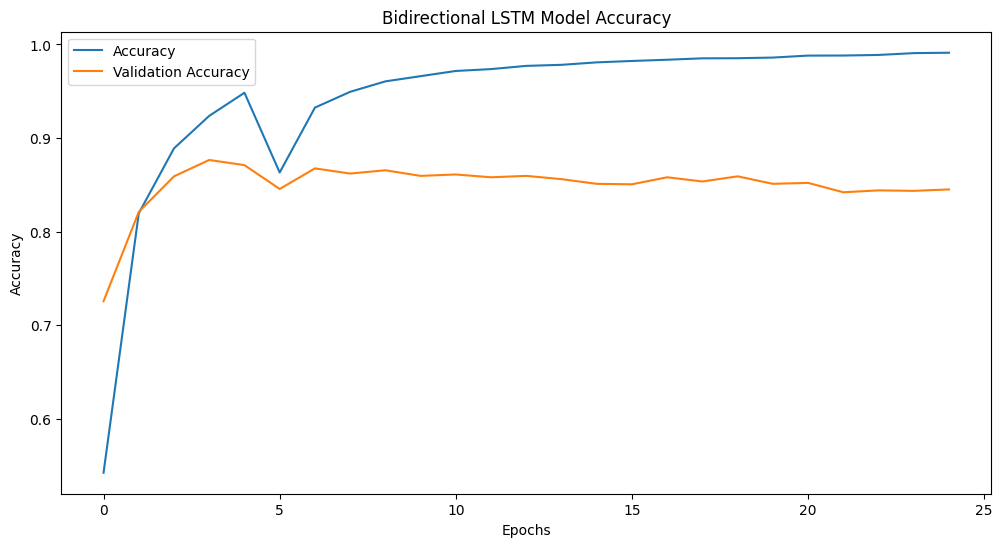

In [125]:
plt.figure(figsize=(12, 6))
plt.title("Bidirectional LSTM Model Accuracy")
plt.plot(model_history.history['accuracy'],label='Accuracy')
plt.plot(model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

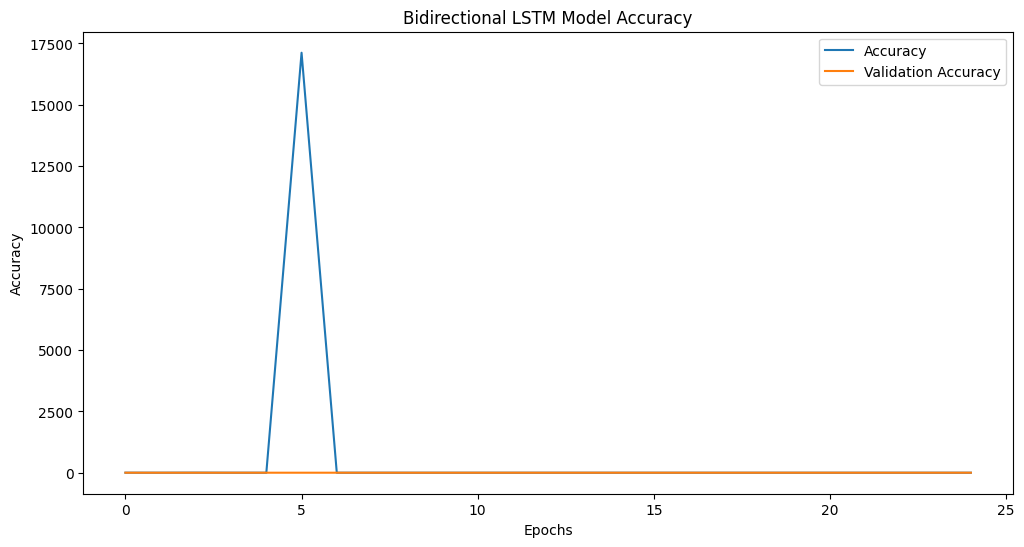

In [126]:
plt.figure(figsize=(12, 6))
plt.title("Bidirectional LSTM Model Accuracy")
plt.plot(model_history.history['loss'],label='Accuracy')
plt.plot(model_history.history['val_loss'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [131]:
from sklearn.metrics import classification_report, accuracy_score

In [135]:
y_pred = clf_model.predict(x_test)
y_pred = np.array([np.argmax(x) for x in y_pred])
print(classification_report(y_test, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       581
           1       0.88      0.87      0.88       695
           2       0.64      0.66      0.65       159
           3       0.84      0.84      0.84       275
           4       0.80      0.84      0.82       224
           5       0.65      0.65      0.65        66

    accuracy                           0.84      2000
   macro avg       0.78      0.79      0.79      2000
weighted avg       0.84      0.84      0.84      2000



In [137]:
# clf_model.save('models/model_0.84.keras')

In [141]:
import pickle

In [142]:
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)